# Citibike Data

This is now being analysed mostly on AWS

In [1]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import dp4gp_histogram
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def get_citibike_data():
    allcb = dp4gp_datasets.load_citibike(station=None)
    subcb = allcb[allcb['usertype']=='Subscriber']

    cb = subcb.ix[random.sample(subcb.index, 5000)]
    inputs = np.c_[cb['start station latitude'],cb['end station latitude'],cb['start station longitude'],cb['end station longitude']]
    ys = cb['tripduration'].values
    return inputs, ys
    

def get_cloaking_prediction(training_inputs, training_ys, test_inputs, sens, eps, delta,noise,modvar,kernval,kern_ls,steps):
    rbf = GPy.kern.RBF(training_inputs.shape[1],kernvar, kern_ls,ARD=True)
    #rbf = GPy.kern.RBF(training_inputs.shape[1],modvar,[5e3,5e3],ARD=True)
    mod = GPy.models.GPRegression(training_inputs,training_ys,rbf)
    mod.Gaussian_noise = noise
    dpgp = dp4gp.DPGP_cloaking(mod,sens,eps,delta)
    return dpgp
     
steps = 3
eps = 1.0

inputs, ys = get_citibike_data()

#FOR CITIBIKE
#squash data into 0-2000 seconds range
ys[ys>2000] = 2000
ys[ys<0] = 0
sens = 2000-0
kernvar = 10.0
kern_ls = np.array([0.01,0.01,0.01,0.01])*5.0

ys_mean = np.mean(ys)
ys_std = np.std(ys)
ys = ys - ys_mean
ys = ys / ys_std
sens = sens / ys_std

training_inputs = inputs[0:-100,:]
training_ys = ys[0:-100][:,None]
test_inputs = inputs[-100:,:]
test_ys = ys[-100:][:,None]

dpgp = get_cloaking_prediction(training_inputs,training_ys,test_inputs,sens,eps,0.01,10.0,1.0, kernvar, kern_ls, steps)
#preds, mu, cov = dpgp.draw_prediction_samples(test_inputs,1,1,1000)

warning in stationary: failed to import cython module: falling back to numpy


(100, 4900)
*
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

 dp4gp.py:481: RuntimeWarning:covariance is not positive-semidefinite.


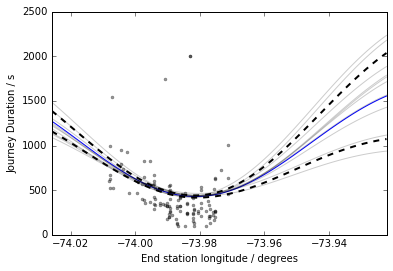

In [2]:
dpgp.plot(fixed_inputs=[(0,40.7404),(2,-73.9828),(1,40.7404)],Nits=500,ys_std=ys_std,ys_mean=ys_mean,plotGPvar=False)
plt.xlabel('End station longitude / degrees')
plt.ylabel('Journey Duration / s')
plt.savefig('citibike_duration.pdf')
#plt.ylim([0,2000])